This file loads datasets of real DGA measurements and generates tuning and noise file which can be loaded in the DGA simulator

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import sklearn.neighbors
import scipy.stats
import statsmodels.api as sm
import pickle
import math

sys.path.insert(0,r'C:\Data\Python\DGA_simulator\simulator')
os.chdir(r'C:\Data\Python\DGA_simulator\simulator')
from pickle_streamer import pickle_streamer
#sys.path.append(r'/home/pdietiker/Dokumente/Python/DGA_simulator/src/GUI')
#sys.path.append(r'/home/pdietiker/Dokumente/Python/DGA_simulator/src')

# Data preparation

load the data set. Each dataset is a 2D array containing the data from several piezo triangle of one channel. 
The piezo triangle has 8322 steps usually

In [27]:

file_ch1=r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane\Sig_pt3 100ppm methane_Master_CH1_2018-01-04__15-22-05.dat"
file_ch2=r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane\Sig_pt3 100ppm methane_Master_CH2_2018-01-04__15-22-05.dat"

file_ch1_background=r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane\Sig_pt4 dry air_Master_CH1_2018-01-04__15-15-39.dat"
file_ch2_background=r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane\Sig_pt4 dry air_Master_CH2_2018-01-04__15-15-39.dat"



load and reshape the data

In [28]:
scan_length=8322
data_ch1_full=np.fromfile(file_ch1,dtype=np.uint16).reshape((-1,scan_length))
data_ch2_full=np.fromfile(file_ch2,dtype=np.uint16).reshape((-1,scan_length))
data_ch1_background_full=np.fromfile(file_ch1_background,dtype=np.uint16).reshape((-1,scan_length))
data_ch2_background_full=np.fromfile(file_ch2_background,dtype=np.uint16).reshape((-1,scan_length))

(4000, 8322)

Plot the data

<IPython.core.display.Javascript object>


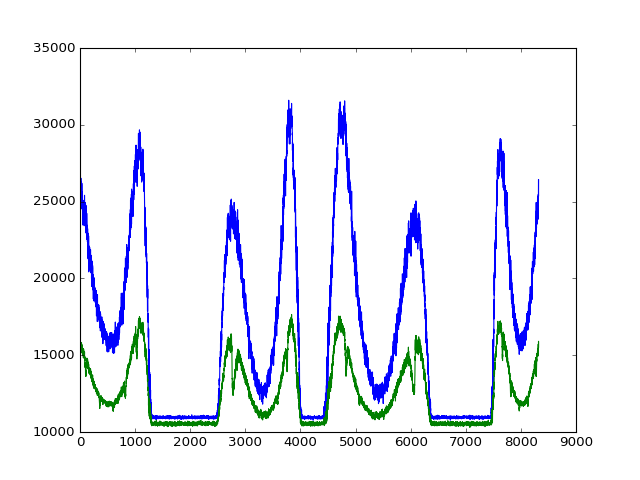

In [29]:
fig, ax=plt.subplots()
ax.plot(data_ch1_full[0])
ax.plot(data_ch2_full[0])

<IPython.core.display.Javascript object>


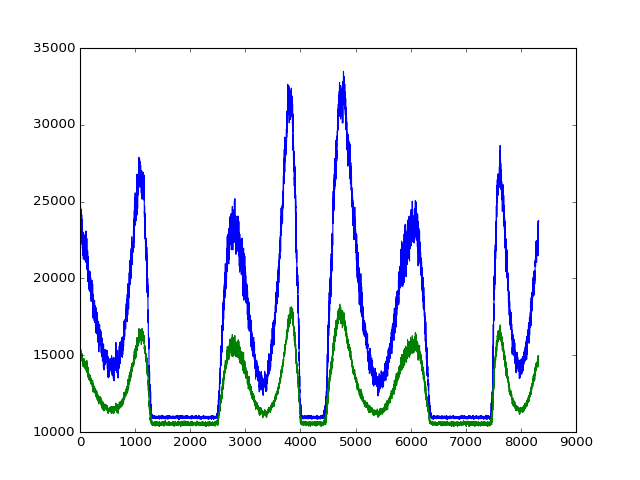

In [30]:
fig, ax=plt.subplots()
ax.plot(data_ch1_background_full[0])
ax.plot(data_ch2_background_full[0])

one has to remove the offset to be able extract the noise correctly. Here we substract the mean value of the detector noise

In [31]:
#remove offset
noise_start=1400
noise_stop=2200
data_ch1_full=data_ch1_full.astype(np.float32)
data_ch2_full=data_ch2_full.astype(np.float32)
data_ch1_background_full=data_ch1_background_full.astype(np.float32)
data_ch2_background_full=data_ch2_background_full.astype(np.float32)
for ch1,ch2,ch1_bg,ch2_bg in zip(data_ch1_full,data_ch2_full,data_ch1_background_full,data_ch2_background_full):
    ch1-=ch1[noise_start:noise_stop].mean()
    ch2-=ch2[noise_start:noise_stop].mean()
    ch1_bg-=ch1_bg[noise_start:noise_stop].mean()
    ch2_bg-=ch2_bg[noise_start:noise_stop].mean()

In [32]:
#check offset correction
data_ch1_background_full[:,noise_start:noise_stop].mean()

-1.251517e-05

In [33]:
#calculate absorbance und signal and background
abs_signal=-np.log(data_ch2_full/data_ch1_full)
abs_background=-np.log(data_ch2_background_full/data_ch1_background_full)
abs_signal-=abs_background

In [34]:
abs_signal.shape

(721, 8322)

In [60]:
np.nanmean(abs_signal,axis=0).shape

(8322,)

<IPython.core.display.Javascript object>


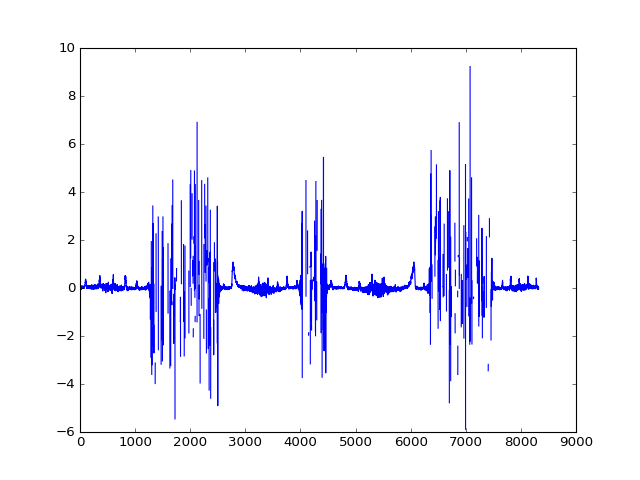

In [35]:
fig, ax=plt.subplots()
ax.plot(abs_signal[2])

Here we select the range of datapoint which gets stored. This is usually from the beginning of the lasing range until the upper turning-point of the piezo triangle

An animation of all the data in the pickle file

<IPython.core.display.Javascript object>


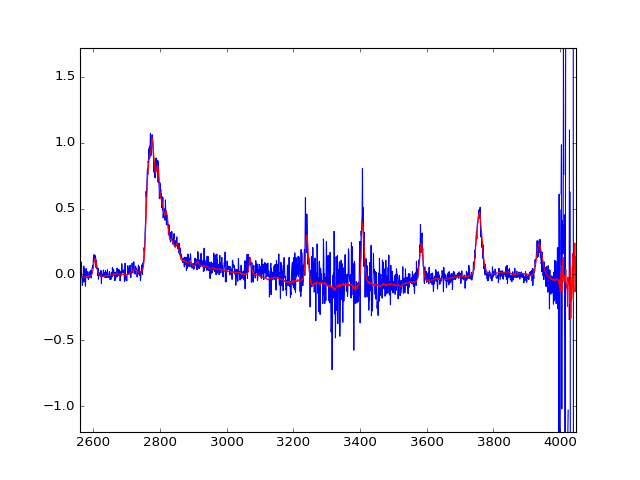

In [38]:
import time
plt.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from matplotlib.animation import FuncAnimation
fig, ax =plt.subplots()
line,=ax.plot(abs_signal[0])
line2,=ax.plot(np.nanmean(abs_signal,axis=0),color="r")
idx=0
class Update(object):
    def __init__(self, line,data):
        self.line=line
        self.index = 0
        self.data=data
        self.iterator=iter(data)
        self.stop=False
    def __call__(self, _):
        if not self.stop:
            try:
                d=self.iterator.next()
            except StopIteration:
                self.stop=True
            else:
                self.line.set_ydata(d)
        return [self.line]

anim = FuncAnimation(fig, Update(line,abs_signal), interval=20, blit=True)    
#anim.save(r"C:\Users\CTCHguest\Desktop\test.avi",writer='ffmpeg',dpi=500,bitrate=1000)

In [50]:
?FuncAnimation

Generate pandas data frame

In [59]:
import pandas as pd
dataframe=pd.DataFrame(abs_signal)

In [64]:
dataframe

0         1         2         3         4         5         6     \
0    0.002807  0.018293  0.021648  0.036161  0.061837  0.013239  0.006984   
1    0.019087  0.018268  0.053669  0.012268  0.045809  0.003104  0.082177   
2    0.009788  0.050135  0.066931  0.040335  0.054063  0.018051  0.005140   
3    0.044704  0.051280  0.009470  0.000913  0.006861  0.005712  0.013968   
4    0.008555  0.037668  0.055190  0.039381  0.019468  0.013481  0.058338   
5    0.036841  0.019896  0.061716  0.066502  0.062973  0.009739 -0.025231   
6    0.020062  0.034691  0.014171  0.008405  0.015561  0.053765 -0.012889   
7    0.018379  0.057064  0.004292  0.049383  0.088138  0.046549  0.011775   
8   -0.006766  0.024187  0.041566  0.001915 -0.021574  0.016679  0.041688   
9   -0.012994  0.004408  0.043117  0.067830  0.036696 -0.029049  0.052799   
10   0.010700  0.009411 -0.028469  0.029663 -0.027233  0.031741  0.038233   
11   0.038136  0.021304  0.073899  0.020161  0.019713  0.010256  0.030270   
12  -0.013270  0.024451  0.034613  0.020689 -0.007307  0.046000  0.017516   
13   0.029463  0.018102 -0.013955  0.036392  0.019801  0.037575 -0.023199   
14  -0.012879  0.056165  0.026165  0.055306 -0.001160  0.014399 -0.037384   
15   0.043167 -0.035550  0.021927 -0.019400 -0.032045  0.053690 -0.003181   
16   0.038562  0.026441  0.016646  0.049301  0.008250 -0.017782  0.031619   
17   0.054176  0.047468  0.024032  0.028751  0.062711  0.030727  0.030835   
18   0.062786 -0.010458  0.002583  0.028406  0.000342 -0.018510  0.030012   
19  -0.007417  0.066393  0.043088  0.035972  0.021842  0.011220 -0.045509   
20   0.036669  0.077651 -0.003612  0.099090  0.059447  0.024702  0.047675   
21   0.013240  0.046363 -0.010504 -0.021060  0.046019 -0.001713  0.001994   
22   0.041410  0.020919  0.008876  0.038913 -0.002499 -0.015728  0.040008   
23   0.008175  0.015549  0.030136  0.025587  0.021361  0.005720  0.052729   
24  -0.006210  0.067344 -0.035094  0.056151  0.030854  0.021028 -0.011165   
25   0.080976  0.012292  0.017157  0.041873  0.028806 -0.000772  0.007726   
26   0.099660  0.055605  0.077629  0.030880  0.036166  0.039978  0.004829   
27   0.051897  0.069491 -0.028925  0.066744  0.016997  0.066939  0.030094   
28  -0.010777  0.000097  0.041840 -0.003036 -0.000499  0.039054  0.052938   
29   0.058583  0.046089  0.042139 -0.033159  0.003297  0.061109  0.001737   
..        ...       ...       ...       ...       ...       ...       ...   
691 -0.015462  0.006720  0.009801 -0.018152 -0.007480  0.027144 -0.010648   
692 -0.028823  0.040360 -0.025286  0.019250 -0.010603 -0.061911  0.020446   
693 -0.016848  0.004651 -0.001038 -0.028690  0.004786  0.036381 -0.036316   
694 -0.033877 -0.009889  0.030259  0.031155  0.019403  0.007646 -0.034809   
695 -0.035391  0.026155  0.011422  0.034743  0.003977 -0.007620 -0.029039   
696 -0.048332  0.053832 -0.030239  0.005797 -0.010708  0.034068 -0.036141   
697 -0.044571 -0.011727  0.005434  0.011716 -0.035817 -0.002432 -0.030505   
698  0.037008  0.006011 -0.014541 -0.032950 -0.029517 -0.017146  0.014032   
699 -0.026207 -0.028099 -0.007537 -0.020747 -0.007727  0.011245 -0.050826   
700  0.040420  0.031368 -0.030020 -0.035422  0.035718  0.020191  0.001432   
701  0.004204  0.022062  0.039430  0.019749 -0.010033  0.021739  0.032690   
702 -0.031661  0.044635 -0.013877 -0.032177  0.039071 -0.007289 -0.019107   
703 -0.056242 -0.002887  0.025670 -0.003636  0.047269 -0.026774  0.039343   
704 -0.016045 -0.092903 -0.050506  0.025464  0.007366 -0.003082 -0.004173   
705 -0.012782 -0.032447 -0.046673 -0.019045 -0.020504 -0.042403 -0.036698   
706  0.062860 -0.002552  0.017102 -0.019079 -0.009118  0.033308 -0.068761   
707  0.035966 -0.023698  0.000261 -0.015545 -0.005518 -0.047926  0.025659   
708  0.025144  0.019167 -0.026585 -0.012472  0.031243 -0.007472  0.020307   
709  0.003618 -0.001828 -0.018963 -0.015532  0.007115  0.015959  0.045982   
710  0.063794 -0.022661  0.026382  0.020616 -0.005544  0.011441  0.031861   
711  

In [16]:
np.savetxt(r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane\100ppm.csv",abs_signal,delimiter=",")

In [2]:
#converter berechnet absorbanz, gibt sie zurueck und speichert sie bei bedarf in ein csv file
def converter(signal_file,reference_file,save_file=None):
    #base_path=os.path.abspath(r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane")
    base_path=os.path.abspath(r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane")
    background_ch1_file="Sig_pt4 dry air_Master_CH1_2018-01-04__15-15-39.dat"
    background_ch2_file="Sig_pt4 dry air_Master_CH2_2018-01-04__15-15-39.dat"
    file_ch1=os.path.join(base_path,signal_file)
    file_ch2=os.path.join(base_path,reference_file)
    file_ch1_background=os.path.join(base_path,background_ch1_file)
    file_ch2_background=os.path.join(base_path,background_ch2_file)
    
    scan_length=8322
    data_ch1_full=np.fromfile(file_ch1,dtype=np.uint16).reshape((-1,scan_length))
    data_ch2_full=np.fromfile(file_ch2,dtype=np.uint16).reshape((-1,scan_length))
    data_ch1_background_full=np.fromfile(file_ch1_background,dtype=np.uint16).reshape((-1,scan_length))
    data_ch2_background_full=np.fromfile(file_ch2_background,dtype=np.uint16).reshape((-1,scan_length))
    
    #set all to same length
    n_obs=min([data_ch1_full.shape[0],data_ch2_full.shape[0],data_ch1_background_full.shape[0],data_ch2_background_full.shape[0]])
    data_ch1_full=data_ch1_full[:n_obs,:]
    data_ch2_full=data_ch2_full[:n_obs,:]
    data_ch1_background_full=data_ch1_background_full[:n_obs,:]
    data_ch2_background_full=data_ch2_background_full[:n_obs,:]
    
    #remove offset
    noise_start=1400
    noise_stop=2200
    #noise_start=800
    #noise_stop=1400
    data_ch1_full=data_ch1_full.astype(np.float32)
    data_ch2_full=data_ch2_full.astype(np.float32)
    data_ch1_background_full=data_ch1_background_full.astype(np.float32)
    data_ch2_background_full=data_ch2_background_full.astype(np.float32)
    for ch1,ch2,ch1_bg,ch2_bg in zip(data_ch1_full,data_ch2_full,data_ch1_background_full,data_ch2_background_full):
        ch1-=ch1[noise_start:noise_stop].mean()
        ch2-=ch2[noise_start:noise_stop].mean()
        ch1_bg-=ch1_bg[noise_start:noise_stop].mean()
        ch2_bg-=ch2_bg[noise_start:noise_stop].mean()
        
    #calculate absorbance und signal and background
    abs_signal=-np.log10(data_ch2_full/data_ch1_full)
    abs_background=-np.log10(data_ch2_background_full/data_ch1_background_full)
    abs_signal-=abs_background
    if save_file is not None:
        np.savetxt(os.path.join(base_path,save_file),abs_signal,delimiter=" ",fmt="%.8f")
    return abs_signal
            
   

In [3]:
#liste der signal files, die verwendet werden sollen

#file list for measurements with polarised laser
file_list_ch1=["Sig_pt5 dry air_Master_CH1_2018-01-04__16-33-41.dat",
               "Sig_pt03 100ppm methane 2 dry air_Master_CH1_2018-01-04__16-27-37.dat",
               "Sig_pt03 100ppm methane 1pt5 dry air_Master_CH1_2018-01-04__16-20-26.dat",
               "Sig_pt03 100ppm methane pt8 dry air_Master_CH1_2018-01-04__16-13-49.dat",
               "Sig_pt05 100ppm methane pt8 dry air_Master_CH1_2018-01-04__15-53-42.dat",
               "Sig_pt03 100ppm methane pt4 dry air_Master_CH1_2018-01-04__16-06-38.dat",
               "Sig_pt05 100ppm methane pt4 dry air_Master_CH1_2018-01-04__15-47-55.dat",
               "Sig_pt1 100ppm methane pt4 dry air_Master_CH1_2018-01-04__15-40-32.dat",
               "Sig_pt3 100ppm methane pt4 dry air_Master_CH1_2018-01-04__15-27-52.dat",
               "Sig_pt6 100ppm methane pt4 dry air_Master_CH1_2018-01-04__15-34-03.dat",
               "Sig_pt3 100ppm methane_Master_CH1_2018-01-04__15-22-05.dat"]

#konzentrationen
conc_list=[0,1.477833,1.960784,3.614458,5.882353,6.976744,11.11111,20,42.8571,60,100]

#file list for measurement with non-polarised laser and much less drift
'''
file_list_ch1=["air and empty reference 25V 8322steps_Master__Ch1_20171020_114253_00000.dat",
                "100ppm methane and empty reference 25V 8322steps_Master__Ch1_20171020_131231_00000.dat"]
conc_list=[0,100]
'''             

#liste der reference files
file_list_ch2=list()
for file_ in file_list_ch1:
    file_list_ch2.append(file_.replace("CH1","CH2"))    

In [9]:
#beispielandwendung von converter
save_path=str(conc_list[7])+"ppm.csv"
a=converter(file_list_ch1[7],file_list_ch2[7],save_path)


In [9]:
#berechnet alle data, speichert sie in all_data und zeigt jeweils die erste spur an
import matplotlib
all_data=list()
fig,ax=plt.subplots()
color=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(conc_list))))
for ch1,ch2,conc in zip(file_list_ch1,file_list_ch2,conc_list):
    save_path=str(conc)+"ppm.csv"
    s=converter(ch1,ch2)
    s=np.insert(s,0,np.repeat(conc,s.shape[0]),axis=1)
    all_data.append(s)
    col=color.next()
    means=np.mean(s,axis=0)
    ax.plot(means,color=col,label=conc)
    s1=s[0,:]
    s2=s[-1,:]
    s1[np.isnan(means)]=np.nan
    s2[np.isnan(means)]=np.nan
    ax.plot(s1,color=col,alpha=0.7)
    ax.plot(s2,color=col,alpha=0.7)
handles,labels=ax.get_legend_handles_labels()
labels=['{:02.1f}'.format(float(x)) for x in labels]
ax.set_xlim([2720,2920])
ax.set_ylim([0.05,0.48])
ax.legend(handles,labels, title="ppm")
plt.savefig(fig,"X:\Public\Peter\DGA-simulator\all_data.bin",dpi=300)

<IPython.core.display.Javascript object>

MemoryError: 

In [12]:
['{:02.1f}'.format(float(x)) for x in labels]

['0.0',
 '1.5',
 '2.0',
 '3.6',
 '7.0',
 '5.9',
 '11.1',
 '20.0',
 '60.0',
 '42.9',
 '100.0']

In [7]:
#zusammenfuehren der daten in einem array
all_data_array=np.concatenate(all_data)

In [3]:
#function to save data as a binary with the array dimensions in the header. This allows for an import in e.g. R. 
def write_binary(file_path,array):
    import struct
    binfile = file(file_path, 'wb')
    header = struct.pack('2I', array.shape[0], array.shape[1])
    binfile.write(header)
    for i in range(array.shape[1]):
        data = struct.pack('%id' % array.shape[0], *array[:,i])
        binfile.write(data)
    binfile.close()  

In [4]:
#speichern aller daten
base_path=os.path.abspath(r"C:\Data\Python\DGA_simulator\Measured_data\20180104 pol laser methane")
write_binary(os.path.join(base_path,"all_data.bin"),all_data_array)

NameError: name 'os' is not defined

In [8]:
all_data_array.shape

(7931, 8323)

In [10]:
all_data[0].shape

(721, 8323)